In [22]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [23]:
data = pd.read_csv('sales-data.csv', header = None)
data.columns = ['Year','Sales']
data['Year'] = pd.to_datetime(data['Year'], format='%Y-%m')
data = data.set_index('Year')
data.head(12)

,Sales
Year,
1980-01-01,154
1980-02-01,96
1980-03-01,73
1980-04-01,49
1980-05-01,36
1980-06-01,59
1980-07-01,95
1980-08-01,169
1980-09-01,219


### Split Timeseries into training and testing dataset

In [24]:
train_len = 60
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

### ADF Test

In [25]:
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(data['Sales'])
print('ADF statitistic: %f '%adf_test[0])
print("Critical value @ 0.05: %.2f"%adf_test[4]['5%'])
print('P-Value: %f' %adf_test[1])

ADF statitistic: 0.581906 
Critical value @ 0.05: -2.91
P-Value: 0.987161


### KPSS Test

In [26]:
from statsmodels.tsa.stattools import kpss
kpss_test=kpss(data['Sales'])
print('kpss statitistic: %f '%kpss_test[0])
print("Critical value @ 0.05: %.2f"%kpss_test[3]['5%'])
print('P-Value: %f' %kpss_test[1])

kpss statitistic: 0.657628 
Critical value @ 0.05: 0.46
P-Value: 0.017397


### BoxCox Transformation

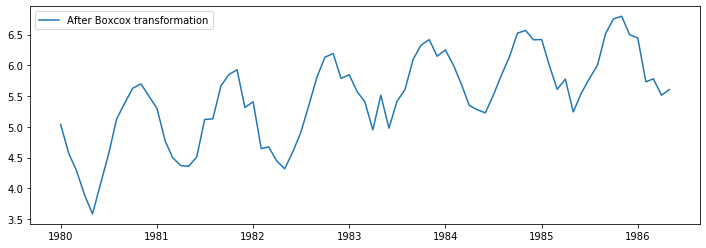

In [27]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Sales'],lmbda=0),index=data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox,label='After Boxcox transformation')
plt.legend(loc='best')
plt.show()

### Differencing

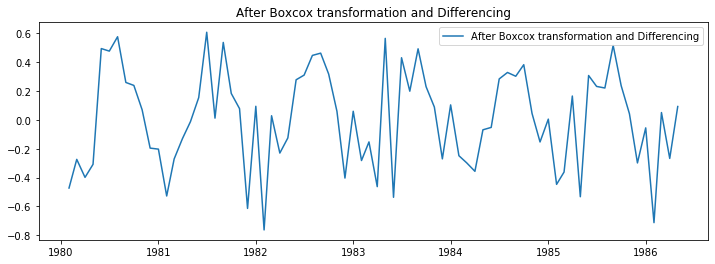

In [28]:
data_boxcox_diff=pd.Series(data_boxcox-data_boxcox.shift(),index=data.index)
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff,label='After Boxcox transformation and Differencing')
plt.legend(loc='best')
plt.title("After Boxcox transformation and Differencing")
plt.show()

### Autocorrelation Function (ACF) Plot

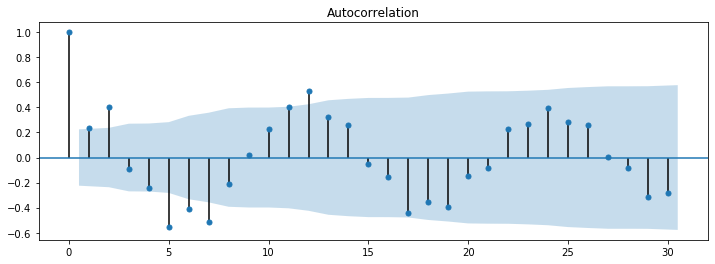

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff,ax=plt.gca(),lags=30)
plt.show()

### Partial Autocorrelation function (PACF) plot

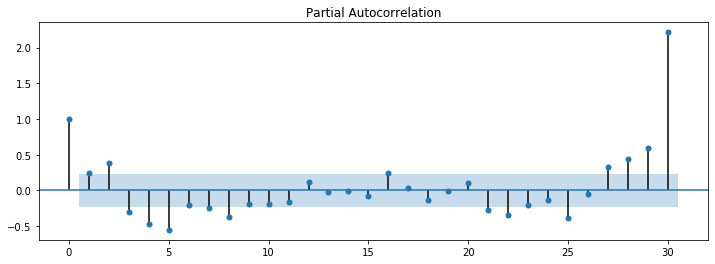

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff,ax=plt.gca(),lags=30)
plt.show()

In [31]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

train_data_boxcox_diff = data_boxcox_diff[:train_len-1] #Here, we drop one value as we had dropped a value due to differencing
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]


## AR

In [32]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order = (8,0,0))
model_fit = model.fit()
print(model_fit.params)

const      0.021119
ar.L1.y   -0.430964
ar.L2.y    0.027075
ar.L3.y   -0.104882
ar.L4.y   -0.113514
ar.L5.y   -0.375209
ar.L6.y   -0.327886
ar.L7.y   -0.496640
ar.L8.y   -0.361155
dtype: float64


In [33]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

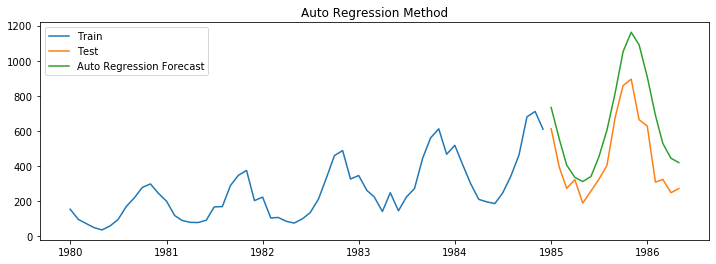

In [34]:
plt.figure(figsize = (12,4))
plt.plot(train['Sales'], label = 'Train')
plt.plot(test['Sales'], label = 'Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label = 'Auto Regression Forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

results = pd.DataFrame({'Method':['Auto Regressive (AR) Method'], 'RMSE': [rmse],'MAPE': [mape] })
# results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Auto Regressive (AR) Method,213.16,47.15


In [36]:
train.tail()

,Sales
Year,
1984-08-01,343
1984-09-01,464
1984-10-01,680
1984-11-01,711
1984-12-01,610
